# Iberdrola Project - Phase 2 [Occupancy Detection]

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [10]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


# Import Libraries

In [11]:
import os
import h5py
import scipy
import random
import pickle
import json
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import loadmat, savemat
from pathlib import Path
from tqdm import tqdm
from scipy import stats

In [12]:
%matplotlib inline
sns.set_style('white')

# Import and Prepare Data

## Prepare Dataset for Training

Import and Extract Data

In [13]:
# Import
fl_Data = h5py.File(os.path.join('Raw_Data/Phase_2_Exp_2/H05_Data_Matched_Occupancy.mat'), 'r')
print(fl_Data.keys())
# Extract
X_Data = np.swapaxes(np.swapaxes(np.array(fl_Data['data_plugs']),0,1),1,2)
Y_Data = np.expand_dims(np.array(fl_Data['data_occupancy']), axis=2)
X_Data_shape = X_Data.shape
Y_Data_shape = Y_Data.shape
print(X_Data_shape)
print(Y_Data_shape)
sample_num = X_Data_shape[0]
segment_length = X_Data_shape[1]
num_channels = X_Data_shape[2]
# Check for NaNs and InFs
data = pd.Series(X_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())

<KeysViewHDF5 ['data_occupancy', 'data_plugs', 'data_sm']>
(74, 86400, 6)
(74, 86400, 1)
False
False
False
False


Plot Raw Segments

In [ ]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
plt.figure(figsize=(32,18))
'''Kitchen_Appliances'''
plt.subplot(7,1,1)
plt.plot(X_Data[i,:,0], linewidth=3, label='Kitchen Appliances GT', color='navy')
plt.title(f"House 05 - Kitchen Appliances - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Microwave'''
plt.subplot(7,1,2)
plt.plot(X_Data[i,:,1], linewidth=3, label='Microwave GT', color='navy')
plt.title(f"Microwave", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Fridge'''
plt.subplot(7,1,3)
plt.plot(X_Data[i,:,2], linewidth=3, label='Fridge GT', color='navy')
plt.title(f"Fridge", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(7,1,4)
plt.plot(X_Data[i,:,3], linewidth=3, label='Entertainment GT', color='navy')
plt.title(f"Entertainment", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''PC and Router'''
plt.subplot(7,1,5)
plt.plot(X_Data[i,:,4], linewidth=3, label='PC and Router GT', color='navy')
plt.title(f"PC and Router", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(7,1,6)
plt.plot(X_Data[i,:,5], linewidth=3, label='Kettle GT', color='navy')
plt.title(f"Kettle", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(7,1,7)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Transform Data

In [14]:
X_Data_Shape = X_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_New = np.zeros((sample_num,segment_length,num_channels))
# Step 1: Range Normalize Data based on [0 1] threshold
counter = 0
threshold1 = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        for iii in range(0,segment_length):
            X_Data_Temp_Ch_Point = X_Data_Temp_Ch[iii]
            if X_Data_Temp_Ch_Point > threshold1:
                X_Data_Temp_Ch_Point = 1
            X_Data_New[counter,iii,ii] = X_Data_Temp_Ch_Point
    counter = counter + 1
X_Data_New = np.int_(X_Data_New[0:counter,:,:])
print(X_Data_New.shape)
print(Y_Data.shape)
print(np.unique(X_Data_New))

(74, 86400, 6)
(74, 86400, 1)
[0 1]


In [15]:
# Step 2: Merge short pulses into longer one based on threshold duration
X_Data_Shape = X_Data_New.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
counter = 0
threshold2 = 3600
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    for ii in range(0,num_channels):
        X_Data_Temp_Ch = X_Data_Temp[:,ii]
        if np.var(X_Data_Temp_Ch) > 0:
            transition_points = []
            for iii in range(1,segment_length):
                X_Data_Temp_Ch_Previous_Point = X_Data_Temp_Ch[iii-1]
                X_Data_Temp_Ch_Current_Point = X_Data_Temp_Ch[iii]
                if X_Data_Temp_Ch_Previous_Point != X_Data_Temp_Ch_Current_Point:
                    transition_points.append(iii)
            # print(transition_points)
            for iii in range(1,len(transition_points)):
                if ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) < 0) and ((transition_points[iii-1]+300) < segment_length):
                    X_Data_Temp_Ch[0:transition_points[iii-1]+300] = 1
                elif ((transition_points[iii-1]-300) >= 0) and ((transition_points[iii-1]+300) >= segment_length):
                    X_Data_Temp_Ch[transition_points[iii-1]-300:segment_length] = 1
                transition_interval = transition_points[iii] - transition_points[iii-1]
                if transition_interval <= threshold2:
                    X_Data_Temp_Ch[transition_points[iii-1]:transition_points[iii]] = 1
        X_Data_New[counter,:,ii] = X_Data_Temp_Ch
    counter = counter + 1
X_Data_New = X_Data_New[0:counter,:,:]
print(X_Data_New.shape)
print(Y_Data.shape)

(74, 86400, 6)
(74, 86400, 1)


Data Pruning - Select channels with an acceptable number of datapoints (optional, for only multichannel)

In [16]:
thresh = 0.05
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
device_list = ['Kitchen Appliances','Microwave','Fridge','Entertainment','PC and Router','Kettle']
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data_New[:,:,i]
    data_current_channel_corr, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    # data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_corr < thresh) or (i == 2):
        print(device_list[i])
        print(data_current_channel_corr)
        continue
    else:
        X_Data_Pruned[:,:,counter] = data_current_channel
        counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Pruned.shape)
print(Y_Data.shape)

Microwave
0.00989543925356319
Fridge
-0.04956170565072658
PC and Router
-0.021836950610700706
(74, 86400, 3)
(74, 86400, 1)


Plot again

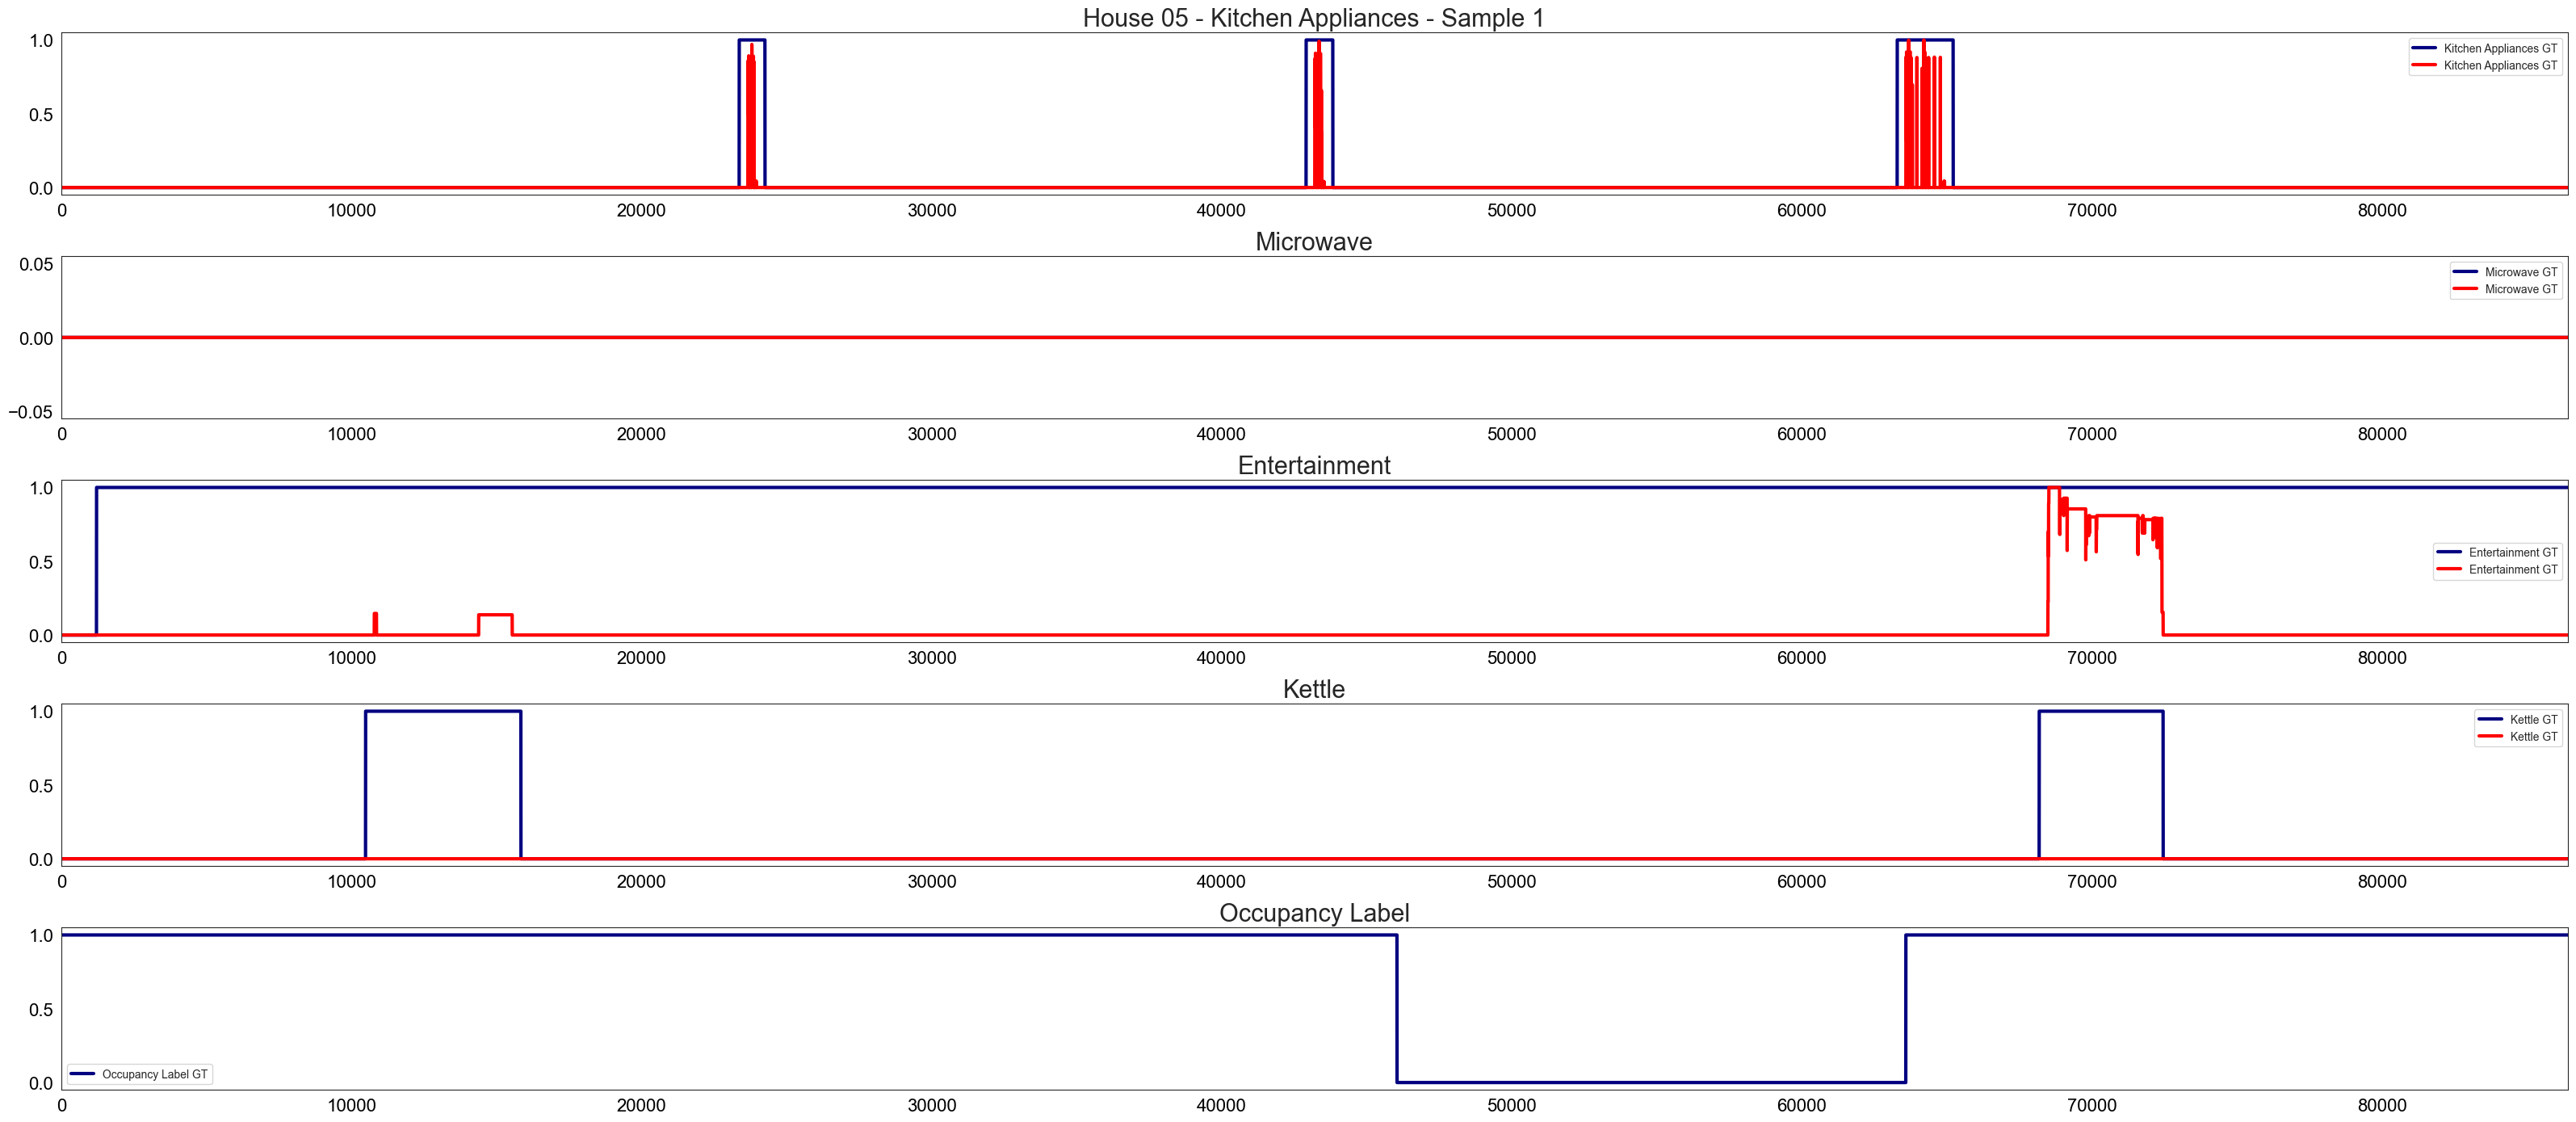

In [43]:
segment_length = 86400
i = random.randint(0, X_Data_shape[0])
plt.figure(figsize=(32,14))
'''Kitchen_Appliances'''
plt.subplot(5,1,1)
plt.plot(X_Data_New[i,:,0], linewidth=3, label='Kitchen Appliances GT', color='navy')
plt.plot(X_Data[i,:,0], linewidth=3, label='Kitchen Appliances GT', color='red')
plt.title(f"House 05 - Kitchen Appliances - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Microwave'''
plt.subplot(5,1,2)
plt.plot(X_Data_New[i,:,1], linewidth=3, label='Microwave GT', color='navy')
plt.plot(X_Data[i,:,1], linewidth=3, label='Microwave GT', color='red')
plt.title(f"Microwave", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Entertainment'''
plt.subplot(5,1,3)
plt.plot(X_Data_New[i,:,2], linewidth=3, label='Entertainment GT', color='navy')
plt.plot(X_Data[i,:,3], linewidth=3, label='Entertainment GT', color='red')
plt.title(f"Entertainment", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Kettle'''
plt.subplot(5,1,4)
plt.plot(X_Data_New[i,:,3], linewidth=3, label='Kettle GT', color='navy')
plt.plot(X_Data[i,:,5], linewidth=3, label='Kettle GT', color='red')
plt.title(f"Kettle", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()
'''Occupancy Label'''
plt.subplot(5,1,5)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Combine Channels

In [17]:
X_Data_Shape = X_Data_New.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_AGG = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_New[i,:,:]
    X_Data_Temp = np.sum(X_Data_Temp, axis=1)
    X_Data_Temp[X_Data_Temp > 0] = 1
    X_Data_AGG[counter,:,0] = X_Data_Temp
    counter = counter + 1
X_Data_AGG = np.int_(X_Data_AGG[0:counter,:,:])
print(X_Data_AGG.shape)
print(Y_Data.shape)
print(np.unique(X_Data_AGG))
print(np.unique(Y_Data))

(74, 86400, 1)
(74, 86400, 1)
[0 1]
[0. 1.]


Plot Aggregated Ground Truth

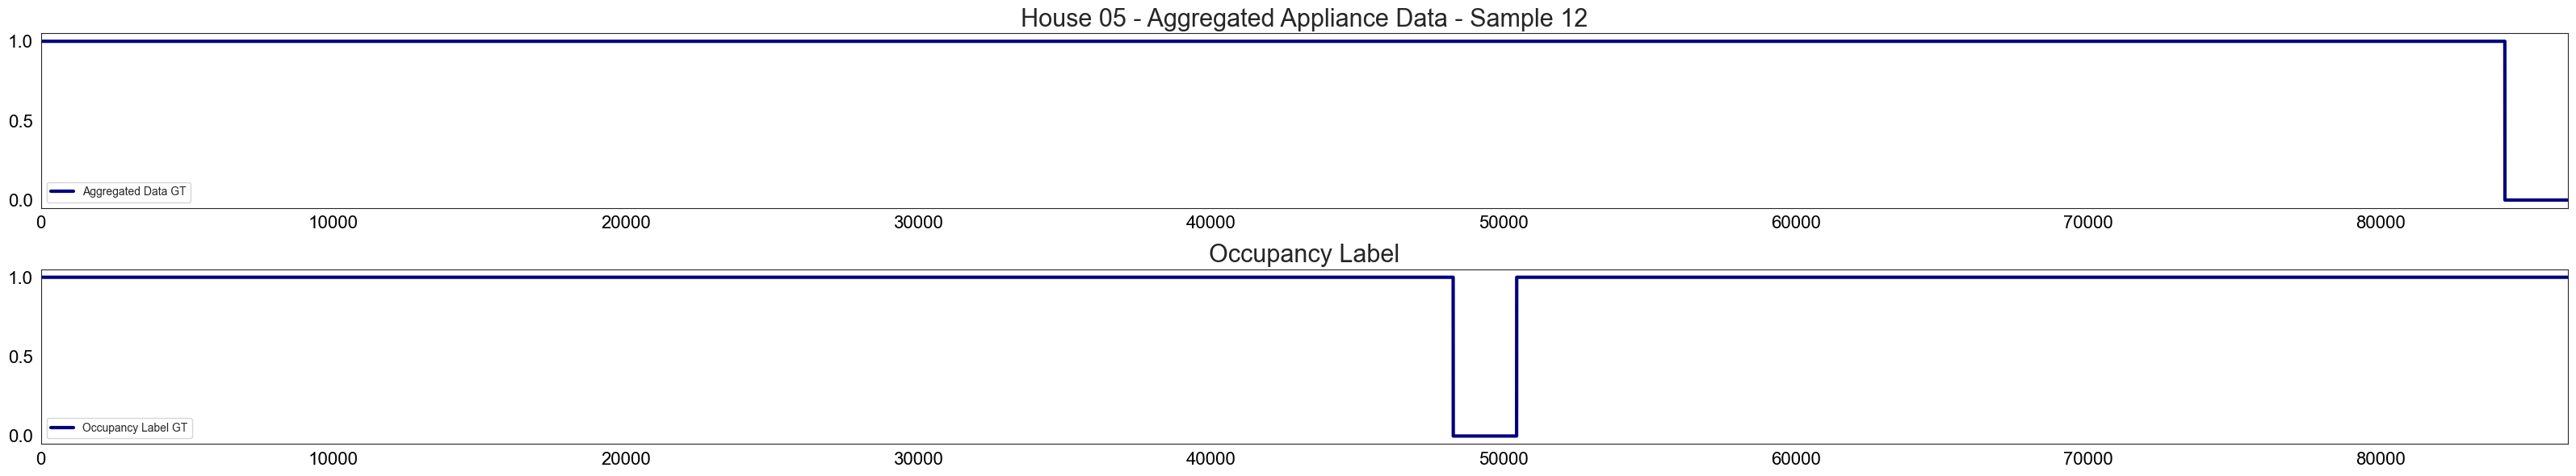

In [20]:
segment_length = 86400
i = random.randint(0, X_Data_AGG.shape[0]-1)
'''Dishwasher'''
plt.figure(figsize=(32,6))
plt.subplot(2,1,1)
plt.plot(X_Data_AGG[i,:,0], linewidth=3, label='Aggregated Data GT', color='navy')
plt.title(f"House 05 - Aggregated Appliance Data - Sample {i}", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
'''Occupancy Label'''
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], linewidth=3, label='Occupancy Label GT', color='navy')
plt.title(f"Occupancy Label", fontdict={'fontsize': 22})
plt.xlim((0,segment_length))
# plt.ylim((0,1))
plt.tick_params(labelsize=16, colors='k')
plt.legend()
plt.tight_layout()

Cleanse and Save House 05 data for the combined approach

In [18]:
# Curate
X_Data_Shape = X_Data_AGG.shape
Y_Data_Shape = Y_Data.shape
sample_num = X_Data_Shape[0]
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
X_Data_Curated = np.zeros((sample_num,segment_length,num_channels))
Y_Data_Curated = np.zeros((sample_num,segment_length,1))
counter = 0
for i in range(0,sample_num):
    X_Data_Temp = X_Data_AGG[i,:,:]
    Y_Data_Temp = Y_Data[i,:,:]
    Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
    if (Y_Data_Temp_SUM < np.round(0.01*segment_length)) or (Y_Data_Temp_SUM > np.round(0.99*segment_length)):
        continue
    if (np.var(X_Data_Temp) > 0.0001):
        X_Data_Curated[counter,:,:] = X_Data_Temp
        Y_Data_Curated[counter,:,:] = Y_Data_Temp
        counter = counter + 1
X_Data_Curated = np.int_(X_Data_Curated[0:counter,:,:])
Y_Data_Curated = np.int_(Y_Data_Curated[0:counter,:,:])
print(X_Data_Curated.shape)
print(Y_Data_Curated.shape)
print(np.unique(X_Data_Curated))
print(np.unique(Y_Data_Curated))
# Save
data_dic = {"X_Data": X_Data_Curated,
            "Y_Data": Y_Data_Curated,
            }
savemat("Occupancy_Data_Curated_House_05_V2.mat", data_dic, format='5')

(31, 86400, 1)
(31, 86400, 1)
[0 1]
[0 1]


Create Folds - Train and Test Sets - 20% for Test - 10% for Validation

In [19]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data_AGG, Y_Data, test_size=0.2, random_state=0)
X_Val = X_Test
Y_Val = Y_Test
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(59, 86400, 1)
(59, 86400, 1)
(15, 86400, 1)
(15, 86400, 1)
(15, 86400, 1)
(15, 86400, 1)


Overlap Train Set

In [20]:
# Overlap
X_Data_Shape = X_Train.shape
Y_Data_Shape = Y_Train.shape
segment_length = X_Data_Shape[1]
num_channels = X_Data_Shape[2]
print(X_Data_Shape)
print(Y_Data_Shape)
# Reshape Array
X_Data_Reshaped = np.reshape(X_Train, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
Y_Data_Reshaped = np.reshape(Y_Train, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
X_Data_Reshaped_Shape = X_Data_Reshaped.shape
Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
print(X_Data_Reshaped_Shape)
print(Y_Data_Reshaped_Shape)
# Overlap
overlap_ratio = 0.9
offset_amount = np.int_(segment_length*(1 - overlap_ratio))
X_Data_New = np.zeros((2000,segment_length,num_channels))
Y_Data_New = np.zeros((2000,segment_length,1))
num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
counter = 0
for i in range(0,num_segments_approx):
    if (i*offset_amount+segment_length) > X_Data_Reshaped_Shape[0]:
        continue
    X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    X_Data_New[counter,:,:] = X_Data_Temp
    Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+segment_length,:]
    Y_Data_New[counter,:,:] = Y_Data_Temp
    counter = counter + 1
X_Train_OVRL = X_Data_New[0:counter,:,:]
Y_Train_OVRL = Y_Data_New[0:counter,:,:]
print(X_Train_OVRL.shape)
print(Y_Train_OVRL.shape)

(59, 86400, 1)
(59, 86400, 1)
(5097600, 1)
(5097600, 1)
(581, 86400, 1)
(581, 86400, 1)


Transform Labels for Classification

In [21]:
def transform_labels(X_Data_OVRL, Y_Data_OVRL, segment_length, num_channels):
    X_Data_New = np.zeros((20000,num_channels,segment_length))
    Y_Data_New = np.zeros((20000,1), dtype=int)
    ## Raw Dataset
    X_Data_Shape = X_Data_OVRL.shape
    Y_Data_Shape = Y_Data_OVRL.shape
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data_OVRL, (X_Data_Shape[0]*X_Data_Shape[1], num_channels))
    Y_Data_Reshaped = np.reshape(Y_Data_OVRL, (Y_Data_Shape[0]*Y_Data_Shape[1], 1))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/segment_length))
    counter = 0
    for i in range(0,num_segments_approx):
        if ((i+1)*segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = np.transpose(X_Data_Reshaped[i*segment_length:(i+1)*segment_length,:])
        X_Data_Temp_Mean = np.mean(X_Data_Temp)
        X_Data_Temp_VAR = np.var(X_Data_Temp)
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*segment_length:(i+1)*segment_length,:]
        Y_Data_Temp_Mean = np.mean(Y_Data_Temp)
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        Y_Data_Temp_SUM = np.sum(Y_Data_Temp)
        if X_Data_Temp_VAR <= 0.001:
            continue
        # if Y_Data_Temp_VAR <= 0.001:
            # continue
        if (Y_Data_Temp_SUM < np.round(0.1*segment_length)) or (Y_Data_Temp_SUM > np.round(0.90*segment_length)):
            continue
        # if Y_Data_Temp_SUM == segment_length:
            # continue
        if Y_Data_Temp_Mean > 0.5:
            Y_Label = 1
        else:
            Y_Label = 0
        Y_Data_New[counter,:] = Y_Label
        counter = counter + 1
    X_Data_New = X_Data_New[0:counter,:,:]
    Y_Data_New = Y_Data_New[0:counter,:]
    return X_Data_New, Y_Data_New

In [22]:
segment_length = 1200  # 20 Minutes = 1200 Data Points (1 Hz sampling rate)
X_Train_C, Y_Train_C = transform_labels(X_Train_OVRL, Y_Train_OVRL, segment_length, num_channels)
X_Test_C, Y_Test_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
X_Val_C, Y_Val_C = transform_labels(X_Test, Y_Test, segment_length, num_channels)
print(X_Train_C.shape)
print(Y_Train_C.shape)
print(X_Test_C.shape)
print(Y_Test_C.shape)
print(X_Val_C.shape)
print(Y_Val_C.shape)
labels, counts = np.unique(Y_Train_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Test_C, return_counts=True)
print(labels, counts)
labels, counts = np.unique(Y_Val_C, return_counts=True)
print(labels, counts)


(100, 1, 1200)
(100, 1)
(5, 1, 1200)
(5, 1)
(5, 1, 1200)
(5, 1)
[0 1] [42 58]
[0 1] [3 2]
[0 1] [3 2]


Balance train set (if required)

In [23]:
Y_Train_0_indices = np.where(Y_Train_C == 0)[0]
X_Train_C_0 = np.take(X_Train_C, Y_Train_0_indices, axis=0)
Y_Train_C_0 = np.take(Y_Train_C, Y_Train_0_indices, axis=0)
Y_Train_1_indices = np.where(Y_Train_C == 1)[0]
X_Train_C_1 = np.take(X_Train_C, Y_Train_1_indices, axis=0)
Y_Train_C_1 = np.take(Y_Train_C, Y_Train_1_indices, axis=0)
#
Y_Train_C_0_shape = Y_Train_C_0.shape
Y_Train_C_1_shape = Y_Train_C_1.shape
Y_Train_C_shape = Y_Train_C.shape
if Y_Train_C_1_shape[0] > Y_Train_C_0_shape[0]:
    index = np.random.choice(Y_Train_C_1_shape[0], Y_Train_C_0_shape[0], replace=False)
    X_Train_1 = X_Train_C_1[index]
    Y_Train_1 = Y_Train_C_1[index]
    X_Train = np.concatenate([X_Train_C_0, X_Train_1], axis=0)
    Y_Train = np.concatenate([Y_Train_C_0, Y_Train_1], axis=0)
elif Y_Train_C_0_shape[0] > Y_Train_C_1_shape[0]:
    index = np.random.choice(Y_Train_C_0_shape[0], Y_Train_C_1_shape[0], replace=False)
    X_Train_0 = X_Train_C_0[index]
    Y_Train_0 = Y_Train_C_0[index]
    X_Train = np.concatenate([X_Train_C_1, X_Train_0], axis=0)
    Y_Train = np.concatenate([Y_Train_C_1, Y_Train_0], axis=0)
#
X_Train_C = X_Train
Y_Train_C = Y_Train
print(X_Train_C.shape)
print(Y_Train_C.shape)

(84, 1, 1200)
(84, 1)


In [24]:
train_data_dic = {"X_Train": X_Train_C,
                  "Y_Train": Y_Train_C,
                  "X_Test": X_Test_C,
                  "Y_Test": Y_Test_C,
                  "X_Val": X_Test_C,
                  "Y_Val": Y_Test_C,
                  }
savemat("Data/Data_Fold_1.mat", train_data_dic, format='5')

Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [25]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'val_size': 0.0,  # Validation percentage for splitting
    'q_order': 3,  # q-order for the Self-ONN or Super-ONN Models
    'batch_size': 2,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'optim_fc': 'Adam',  # 'Adam' or 'SGD'
    'lr': 0.0005,  # learning rate
    'stop_criteria': 'accuracy',  # Stopping criteria: 'loss' or 'accuracy'
    'n_epochs': 500,  # number of training epochs
    'epochs_patience': 6,
    'lr_factor': 0.1,  # lr_factor, if val loss did not decrease for a number of epochs (epochs_patience) then decrease learning rate by a factor of lr_factor
    'max_epochs_stop': 30,  # maximum number of epochs with no improvement in validation loss for early stopping
    'num_folds': 1,  # number of cross validation folds
    'load_model': False,  # load model: True or False
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'model_to_load': 'RODNet',  # choose one of the following models: 'CNN_1' 'CNN_2' 'CNN_2' 'CNN_3' 'SelfResNet18' 'ResNet'
    'model_name': 'RODNet_Occp_Classification',  # choose a unique name for result folder
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}

# SAVE CONFIG FILE
with open(r"Config_Train.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Config_Train.ini' created")

Config file 'Config_Train.ini' created


## Train

In [26]:
%run -i Train.py

Train on gpu: True
1 GPUs detected.
Training using RODNet network
Starting training with Fold 1
Shape of Train Data: (84, 1, 1200)
Shape of Train Label: (84, 1)
Shape of Validation Data: (5, 1, 1200)
Shape of Validation Label: (5, 1)
Shape of Test Data: (5, 1, 1200)
Shape of Test Label: (5, 1)
Classes: [0 1]
No. of Classes: 2
model device: cuda
Starting Training from Scratch.



Epoch 0: 100%|██████████| 42/42 [00:00<00:00, 47.92it/s]
c:\Users\Sakib Mahmud\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch: 0 	Training Loss: 0.2340 	Validation Loss: 0.1384 	Test Loss: 0.1384
		Training Accuracy: 63.10%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 1: 100%|██████████| 42/42 [00:00<00:00, 74.88it/s]



Epoch: 1 	Training Loss: 0.2115 	Validation Loss: 0.1463 	Test Loss: 0.1463
		Training Accuracy: 70.24%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 2: 100%|██████████| 42/42 [00:00<00:00, 73.92it/s]



Epoch: 2 	Training Loss: 0.2179 	Validation Loss: 0.1785 	Test Loss: 0.1785
		Training Accuracy: 60.71%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 3: 100%|██████████| 42/42 [00:00<00:00, 79.47it/s]



Epoch: 3 	Training Loss: 0.2114 	Validation Loss: 0.1705 	Test Loss: 0.1705
		Training Accuracy: 65.48%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 4: 100%|██████████| 42/42 [00:00<00:00, 81.13it/s]



Epoch: 4 	Training Loss: 0.2116 	Validation Loss: 0.1339 	Test Loss: 0.1339
		Training Accuracy: 64.29%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 5: 100%|██████████| 42/42 [00:00<00:00, 78.02it/s]



Epoch: 5 	Training Loss: 0.1914 	Validation Loss: 0.1319 	Test Loss: 0.1319
		Training Accuracy: 67.86%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 6: 100%|██████████| 42/42 [00:00<00:00, 81.30it/s]



Epoch: 6 	Training Loss: 0.2003 	Validation Loss: 0.1568 	Test Loss: 0.1568
		Training Accuracy: 70.24%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 7: 100%|██████████| 42/42 [00:00<00:00, 77.06it/s]



Epoch: 7 	Training Loss: 0.1918 	Validation Loss: 0.1407 	Test Loss: 0.1407
		Training Accuracy: 71.43%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 8: 100%|██████████| 42/42 [00:00<00:00, 80.80it/s]



Epoch: 8 	Training Loss: 0.1934 	Validation Loss: 0.1605 	Test Loss: 0.1605
		Training Accuracy: 70.24%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 9: 100%|██████████| 42/42 [00:00<00:00, 76.63it/s]



Epoch: 9 	Training Loss: 0.2066 	Validation Loss: 0.1735 	Test Loss: 0.1735
		Training Accuracy: 69.05%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 10: 100%|██████████| 42/42 [00:00<00:00, 78.44it/s]



Epoch: 10 	Training Loss: 0.1995 	Validation Loss: 0.2693 	Test Loss: 0.2693
		Training Accuracy: 65.48%	 Validation Accuracy: 60.00%	 Test Accuracy: 60.00%


Epoch 11: 100%|██████████| 42/42 [00:00<00:00, 84.07it/s]



Epoch: 11 	Training Loss: 0.2167 	Validation Loss: 0.1741 	Test Loss: 0.1741
		Training Accuracy: 64.29%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 12: 100%|██████████| 42/42 [00:00<00:00, 76.36it/s]



Epoch: 12 	Training Loss: 0.1873 	Validation Loss: 0.2022 	Test Loss: 0.2022
		Training Accuracy: 69.05%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 13: 100%|██████████| 42/42 [00:00<00:00, 79.83it/s]



Epoch: 13 	Training Loss: 0.1815 	Validation Loss: 0.2935 	Test Loss: 0.2935
		Training Accuracy: 71.43%	 Validation Accuracy: 60.00%	 Test Accuracy: 60.00%


Epoch 14: 100%|██████████| 42/42 [00:00<00:00, 73.19it/s]



Epoch: 14 	Training Loss: 0.1905 	Validation Loss: 0.1297 	Test Loss: 0.1297
		Training Accuracy: 69.05%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 15: 100%|██████████| 42/42 [00:00<00:00, 82.40it/s]



Epoch: 15 	Training Loss: 0.1864 	Validation Loss: 0.1552 	Test Loss: 0.1552
		Training Accuracy: 70.24%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 16: 100%|██████████| 42/42 [00:00<00:00, 83.12it/s]



Epoch: 16 	Training Loss: 0.1800 	Validation Loss: 0.1386 	Test Loss: 0.1386
		Training Accuracy: 67.86%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 17: 100%|██████████| 42/42 [00:00<00:00, 80.83it/s]



Epoch: 17 	Training Loss: 0.1729 	Validation Loss: 0.1539 	Test Loss: 0.1539
		Training Accuracy: 73.81%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 18: 100%|██████████| 42/42 [00:00<00:00, 76.08it/s]



Epoch: 18 	Training Loss: 0.1834 	Validation Loss: 0.2448 	Test Loss: 0.2448
		Training Accuracy: 73.81%	 Validation Accuracy: 60.00%	 Test Accuracy: 60.00%


Epoch 19: 100%|██████████| 42/42 [00:00<00:00, 78.76it/s]



Epoch: 19 	Training Loss: 0.1698 	Validation Loss: 0.1644 	Test Loss: 0.1644
		Training Accuracy: 73.81%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 20: 100%|██████████| 42/42 [00:00<00:00, 83.95it/s]



Epoch: 20 	Training Loss: 0.1642 	Validation Loss: 0.1483 	Test Loss: 0.1483
		Training Accuracy: 72.62%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 21: 100%|██████████| 42/42 [00:00<00:00, 79.89it/s]



Epoch: 21 	Training Loss: 0.1608 	Validation Loss: 0.1443 	Test Loss: 0.1443
		Training Accuracy: 72.62%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 22: 100%|██████████| 42/42 [00:00<00:00, 84.39it/s]



Epoch: 22 	Training Loss: 0.1653 	Validation Loss: 0.2140 	Test Loss: 0.2140
		Training Accuracy: 70.24%	 Validation Accuracy: 60.00%	 Test Accuracy: 60.00%


Epoch 23: 100%|██████████| 42/42 [00:00<00:00, 78.07it/s]



Epoch: 23 	Training Loss: 0.1800 	Validation Loss: 0.1554 	Test Loss: 0.1554
		Training Accuracy: 76.19%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 24: 100%|██████████| 42/42 [00:00<00:00, 82.68it/s]



Epoch: 24 	Training Loss: 0.1741 	Validation Loss: 0.2505 	Test Loss: 0.2505
		Training Accuracy: 72.62%	 Validation Accuracy: 60.00%	 Test Accuracy: 60.00%


Epoch 25: 100%|██████████| 42/42 [00:00<00:00, 86.55it/s]



Epoch: 25 	Training Loss: 0.1592 	Validation Loss: 0.1514 	Test Loss: 0.1514
		Training Accuracy: 72.62%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 26: 100%|██████████| 42/42 [00:00<00:00, 70.61it/s]



Epoch: 26 	Training Loss: 0.1761 	Validation Loss: 0.1532 	Test Loss: 0.1532
		Training Accuracy: 73.81%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 27: 100%|██████████| 42/42 [00:00<00:00, 78.95it/s]



Epoch: 27 	Training Loss: 0.1708 	Validation Loss: 0.1579 	Test Loss: 0.1579
		Training Accuracy: 71.43%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 28: 100%|██████████| 42/42 [00:00<00:00, 76.86it/s]



Epoch: 28 	Training Loss: 0.1566 	Validation Loss: 0.1330 	Test Loss: 0.1330
		Training Accuracy: 75.00%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 29: 100%|██████████| 42/42 [00:00<00:00, 84.94it/s]



Epoch: 29 	Training Loss: 0.1689 	Validation Loss: 0.1359 	Test Loss: 0.1359
		Training Accuracy: 76.19%	 Validation Accuracy: 80.00%	 Test Accuracy: 80.00%


Epoch 30: 100%|██████████| 42/42 [00:00<00:00, 74.89it/s]



Epoch: 30 	Training Loss: 0.1642 	Validation Loss: 0.2495 	Test Loss: 0.2495
		Training Accuracy: 71.43%	 Validation Accuracy: 60.00%	 Test Accuracy: 60.00%

Early Stopping! Total epochs: 30. Best epoch: 0 with loss: 0.14 and acc: 80.00%
17.67 total seconds elapsed. 0.57 seconds per epoch.
Test Loss: 0.1384,  Test Accuracy: 80.0%
completed fold 1
#############################################################
Cummulative Confusion Matrix
[[3 0]
 [1 1]]
Overall Test Accuracy: 80.0
#############################################################


## Test

In [69]:
# CREATE OBJECT
config_file = configparser.ConfigParser()
# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
    'parentdir': '',  # Root or Parent Directory
    'datafile': 'Data',  # Folder containing the dataset
    'batch_size': 1,  # Batch Size, Change to fit hardware
    'lossType': 'SoftM_MSE',  # loss function: 'SoftM_CELoss' or 'SoftM_MSE' or 'MSE'
    'num_folds': 1,  # number of cross validation folds
    'CI': 0.9,  # Confidence interval (missied cases with probability>=CI will be reported in excel file)
    'load_model': False,  # specify path of pretrained model wieghts or set to False to train from scratch
    'load_model_path': 'Results_Classification\RODNet_Occp_Classification\Fold_1\RODNet_Occp_Classification_fold_1.pt',  # specify path of pretrained model wieghts or set to False to train from scratch
    'labeled_data': True,  # set to true if you have the labeled test set
    'model_name': 'RODNet_Occp_Classification',  # name of the saved model
    'aux_logits': False,  # Required for models with auxilliary outputs (e.g., InceptionV3)  
    'fold_start': 1,  # The starting fold for training
    'fold_last': 1,  # The last fold for training
    'N_steps': 1000,  # The last fold for training
    'results_path': 'Results_Classification',  # main results folder
}
# SAVE CONFIG FILE
with open(r"Config_Test.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Config_Test.ini' created")

Config file 'Config_Test.ini' created


In [ ]:
%run -i Test.py